In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [4]:
np.random.seed(42)
companies = [
    "Reliance","TCS","HDFC Bank","Infosys","ITC","Larsen & Toubro","Bharti Airtel",
    "HCL Tech","Asian Paints","Maruti Suzuki","ICICI Bank","Kotak Mahindra",
    "Mahindra & Mahindra","Hindustan Unilever","Bajaj Finance","Nestle India",
    "Power Grid","ONGC","Titan","Wipro"
]

gov = pd.DataFrame({
    "Company": companies,
    # Indicator values: 1 = Yes/Good, 0 = No/Bad (or integer for counts)
    "Board_Independence_pct": np.round(np.random.uniform(30, 80, len(companies)),1),  # percent independent directors
    "Audit_Committee_Exist": np.random.choice([1,1,1,0], size=len(companies)),        # mostly present
    "Exec_Comp_Transparent": np.random.choice([1,1,0], size=len(companies)),
    "Whistleblower_Policy": np.random.choice([1,1,0], size=len(companies)),
    "Regulatory_Penalties_count": np.random.choice([0,0,0,1,2], size=len(companies)),
    "Related_Party_Transactions_flag": np.random.choice([0,0,1], size=len(companies)),
    "External_Audit_OK": np.random.choice([1,1,1,0], size=len(companies)),
    "Fraud_History_flag": np.random.choice([0,0,1], size=len(companies)),
    "Minority_Shareholder_Rights": np.random.choice([1,1,0], size=len(companies))
})

In [5]:
gov['Board_Independence_score'] = gov['Board_Independence_pct']  # already 0-100-ish

In [6]:
binary_cols = ['Audit_Committee_Exist','Exec_Comp_Transparent','Whistleblower_Policy',
               'External_Audit_OK','Minority_Shareholder_Rights']
for c in binary_cols:
    gov[c + '_score'] = gov[c] * 100

In [7]:
gov['Regulatory_Penalty_penalty'] = np.minimum(gov['Regulatory_Penalties_count'] * 50, 100)
gov['Regulatory_Penalty_score'] = 100 - gov['Regulatory_Penalty_penalty']

gov['RelatedParty_penalty'] = gov['Related_Party_Transactions_flag'] * 100
gov['RelatedParty_score'] = 100 - gov['RelatedParty_penalty']

gov['Fraud_penalty'] = gov['Fraud_History_flag'] * 100
gov['Fraud_score'] = 100 - gov['Fraud_penalty']

In [9]:
weights = {
    'Board_Independence_score': 0.25,
    'Audit_Committee_Exist_score': 0.10,
    'Exec_Comp_Transparent_score': 0.10,
    'Whistleblower_Policy_score': 0.10,
    'External_Audit_OK_score': 0.10,
    'Minority_Shareholder_Rights_score': 0.10,
    'Regulatory_Penalty_score': 0.10,
    'RelatedParty_score': 0.10,
    'Fraud_score': 0.15  # overlap okay; weights sum >1 intentionally to emphasize fraud — we'll normalize below
}

In [10]:
w_total = sum(weights.values())
weights = {k: v / w_total for k, v in weights.items()}

In [11]:
gov['Governance_score'] = 0
for key, w in weights.items():
    gov['Governance_score'] += gov[key] * w

In [12]:
gov['Governance_score'] = gov['Governance_score'].round(2)

In [13]:
gov['High_Risk_Flag'] = 0
# Flag if governance score low or any severe negative indicator
gov.loc[(gov['Governance_score'] < 50) | (gov['Fraud_History_flag']==1) | (gov['Regulatory_Penalties_count']>=2), 'High_Risk_Flag'] = 1
gov['Medium_Risk_Flag'] = 0
gov.loc[(gov['Governance_score'].between(50,70)) & (gov['High_Risk_Flag']==0), 'Medium_Risk_Flag'] = 1

In [14]:
top_gov = gov.sort_values('Governance_score', ascending=False).head(5)
risks = gov[gov['High_Risk_Flag']==1].sort_values('Governance_score')

print("Top 5 Governance Performers:")
display(top_gov[['Company','Board_Independence_pct','Governance_score']])

print("\nCompanies flagged High Risk (governance):")
display(risks[['Company','Governance_score','Fraud_History_flag','Regulatory_Penalties_count','Related_Party_Transactions_flag']])

Top 5 Governance Performers:


,Company,Board_Independence_pct,Governance_score
12,Mahindra & Mahindra,71.6,93.55
11,Kotak Mahindra,78.5,86.02
7,HCL Tech,73.3,84.84
6,Bharti Airtel,32.9,75.66
8,Asian Paints,60.1,72.75



Companies flagged High Risk (governance):


,Company,Governance_score,Fraud_History_flag,Regulatory_Penalties_count,Related_Party_Transactions_flag
4,ITC,26.77,1,0,1
3,Infosys,40.89,1,2,0
0,Reliance,42.89,1,1,1
15,Nestle India,45.27,1,0,0
19,Wipro,51.05,1,1,0
16,Power Grid,55.73,1,0,0
10,ICICI Bank,57.05,1,1,1
18,Titan,57.18,1,0,1
5,Larsen & Toubro,58.59,0,2,1
13,Hindustan Unilever,59.23,0,2,1


/tmp/ipython-input-3961614518.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Governance_score', y='Company', data=gov.sort_values('Governance_score', ascending=False), palette='coolwarm')


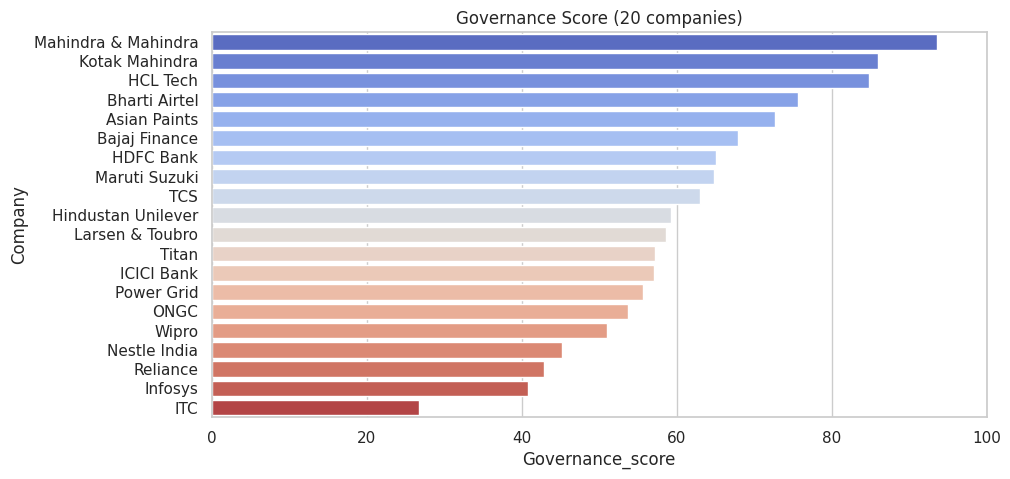

In [15]:
plt.figure(figsize=(10,5))
sns.barplot(x='Governance_score', y='Company', data=gov.sort_values('Governance_score', ascending=False), palette='coolwarm')
plt.title('Governance Score (20 companies)')
plt.xlim(0,100)
plt.show()

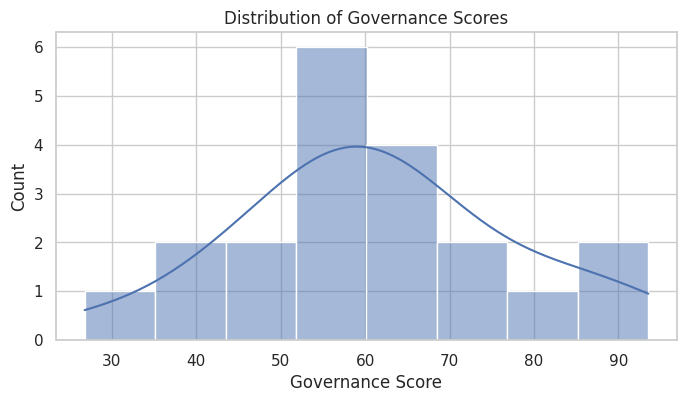

In [16]:
plt.figure(figsize=(8,4))
sns.histplot(gov['Governance_score'], bins=8, kde=True)
plt.title('Distribution of Governance Scores')
plt.xlabel('Governance Score')
plt.show()

In [18]:
# Top 5 Companies by Governance Score
top5_gov = gov.sort_values(by='Governance_score', ascending=False).head(5)
print("Top 5 Companies by Governance Score:")
display(top5_gov[['Company', 'Governance_score']])

Top 5 Companies by Governance Score:


,Company,Governance_score
12,Mahindra & Mahindra,93.55
11,Kotak Mahindra,86.02
7,HCL Tech,84.84
6,Bharti Airtel,75.66
8,Asian Paints,72.75


Average Governance Score across all companies: 61.11


/tmp/ipython-input-3168440294.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Company', y='Governance_score', data=top10_gov, palette='crest')


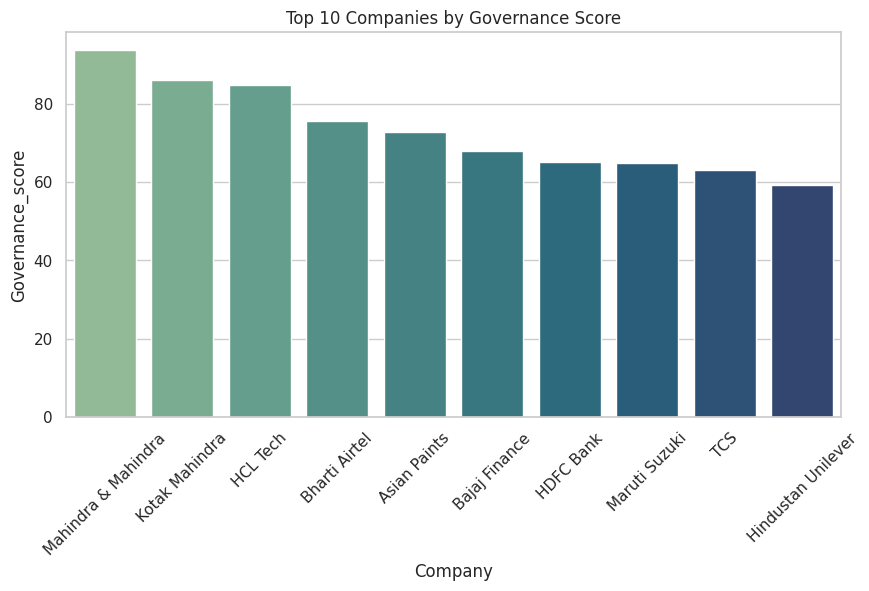

In [20]:
# Average Governance Score (overall)
avg_gov_score = gov['Governance_score'].mean()
print(f"Average Governance Score across all companies: {avg_gov_score:.2f}")

# Bar chart: Top 10 companies by Governance score
top10_gov = gov.sort_values(by='Governance_score', ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x='Company', y='Governance_score', data=top10_gov, palette='crest')
plt.title('Top 10 Companies by Governance Score')
plt.xticks(rotation=45)
plt.show()

In [23]:
# Step 0: Re-create ESG dataset (20 companies)
import pandas as pd
import numpy as np

data = {
    "Company": [
        "Reliance", "TCS", "HDFC Bank", "Infosys", "ITC",
        "Larsen & Toubro", "Bharti Airtel", "HCL Tech", "Asian Paints", "Maruti Suzuki",
        "ICICI Bank", "Kotak Mahindra", "Mahindra & Mahindra", "Hindustan Unilever",
        "Bajaj Finance", "Nestle India", "Power Grid", "ONGC", "Titan", "Wipro"
    ],
    "Ticker": [
        "RELIANCE", "TCS", "HDFCBANK", "INFY", "ITC",
        "LT", "BHARTIARTL", "HCLTECH", "ASIANPAINT", "MARUTI",
        "ICICIBANK", "KOTAKBANK", "M&M", "HINDUNILVR",
        "BAJFINANCE", "NESTLEIND", "POWERGRID", "ONGC", "TITAN", "WIPRO"
    ],
    "Sector": [
        "Energy", "IT", "Finance", "IT", "Consumer",
        "Industrials", "Telecom", "IT", "Consumer", "Automobile",
        "Finance", "Finance", "Automobile", "Consumer",
        "Finance", "Consumer", "Utilities", "Energy", "Consumer", "IT"
    ],
    "Country": ["India"]*20,
    "E_score": np.random.randint(50, 90, 20).astype(float),
    "S_score": np.random.randint(50, 90, 20).astype(float),
    "G_score": np.random.randint(50, 90, 20).astype(float),
    "Controversies": np.random.randint(0,2,20),
    "Revenue_million_usd": np.random.randint(1000, 50000, 20).astype(float),
    "NetIncome_million_usd": np.random.randint(100, 10000, 20).astype(float),
    "MarketCap_million_usd": np.random.randint(5000, 300000, 20).astype(float),
    "StockReturn_1Y_pct": np.random.uniform(-10, 50, 20)
}

df = pd.DataFrame(data)

# Handle missing values and calculate Custom ESG
for col in ['E_score','S_score','G_score']:
    df[col].fillna(df[col].mean(), inplace=True)
df['Custom_ESG'] = df[['E_score','S_score','G_score']].mean(axis=1)

df.head()

/tmp/ipython-input-3127019702.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


,Company,Ticker,Sector,Country,E_score,S_score,G_score,Controversies,Revenue_million_usd,NetIncome_million_usd,MarketCap_million_usd,StockReturn_1Y_pct,Custom_ESG
0,Reliance,RELIANCE,Energy,India,82.0,52.0,87.0,1,31306.0,2355.0,117296.0,37.688678,73.666667
1,TCS,TCS,IT,India,50.0,86.0,73.0,1,17646.0,1254.0,99179.0,20.158226,69.666667
2,HDFC Bank,HDFCBANK,Finance,India,76.0,66.0,54.0,0,47843.0,4599.0,95272.0,24.614233,65.333333
3,Infosys,INFY,IT,India,62.0,51.0,83.0,1,32065.0,6395.0,43467.0,19.551062,65.333333
4,ITC,ITC,Consumer,India,52.0,51.0,55.0,0,26199.0,6297.0,290472.0,1.714579,52.666667


In [24]:
# Merge ESG and Governance datasets
# Assuming your ESG data is in `df` and Governance data is in `gov`

full_esg = pd.merge(df, gov[['Company', 'Governance_score']], on='Company', how='left')

# Check the merged dataset
full_esg.head()

,Company,Ticker,Sector,Country,E_score,S_score,G_score,Controversies,Revenue_million_usd,NetIncome_million_usd,MarketCap_million_usd,StockReturn_1Y_pct,Custom_ESG,Governance_score
0,Reliance,RELIANCE,Energy,India,82.0,52.0,87.0,1,31306.0,2355.0,117296.0,37.688678,73.666667,42.89
1,TCS,TCS,IT,India,50.0,86.0,73.0,1,17646.0,1254.0,99179.0,20.158226,69.666667,63.07
2,HDFC Bank,HDFCBANK,Finance,India,76.0,66.0,54.0,0,47843.0,4599.0,95272.0,24.614233,65.333333,65.14
3,Infosys,INFY,IT,India,62.0,51.0,83.0,1,32065.0,6395.0,43467.0,19.551062,65.333333,40.89
4,ITC,ITC,Consumer,India,52.0,51.0,55.0,0,26199.0,6297.0,290472.0,1.714579,52.666667,26.77


Top 5 Companies by Custom ESG Score:


,Company,Sector,Country,Custom_ESG
8,Asian Paints,Consumer,India,79.666667
5,Larsen & Toubro,Industrials,India,78.666667
14,Bajaj Finance,Finance,India,77.000000
16,Power Grid,Utilities,India,74.000000
15,Nestle India,Consumer,India,73.666667


Top 5 Companies by Governance Score:


,Company,Sector,Country,Governance_score
12,Mahindra & Mahindra,Automobile,India,93.55
11,Kotak Mahindra,Finance,India,86.02
7,HCL Tech,IT,India,84.84
6,Bharti Airtel,Telecom,India,75.66
8,Asian Paints,Consumer,India,72.75


/tmp/ipython-input-795750141.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_avg.index, y=sector_avg.values, palette='viridis')


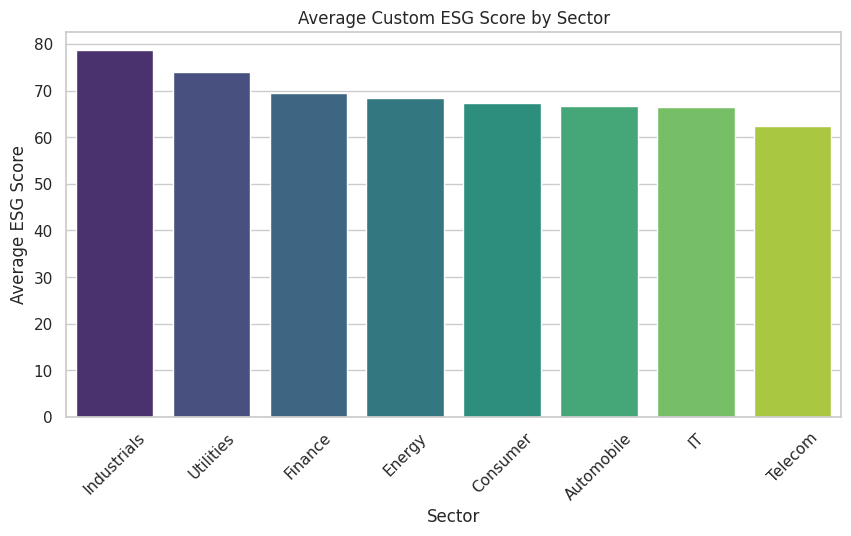

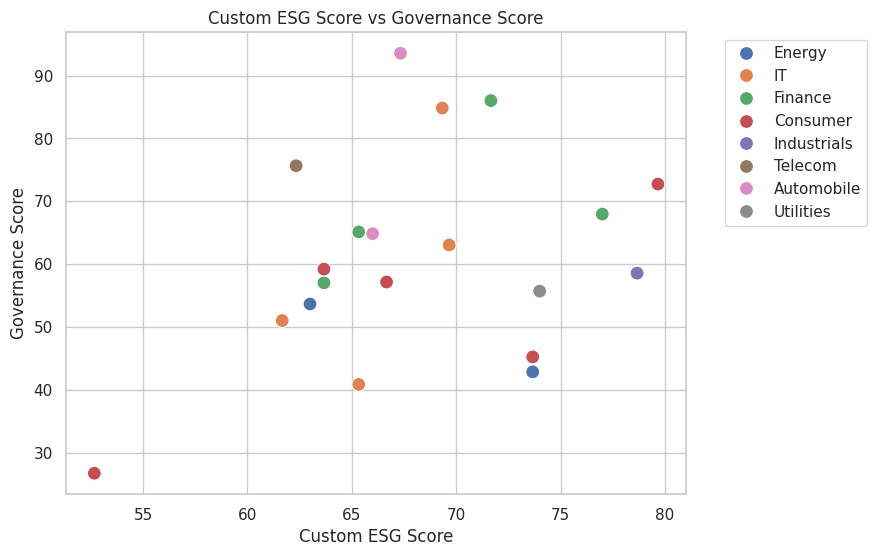

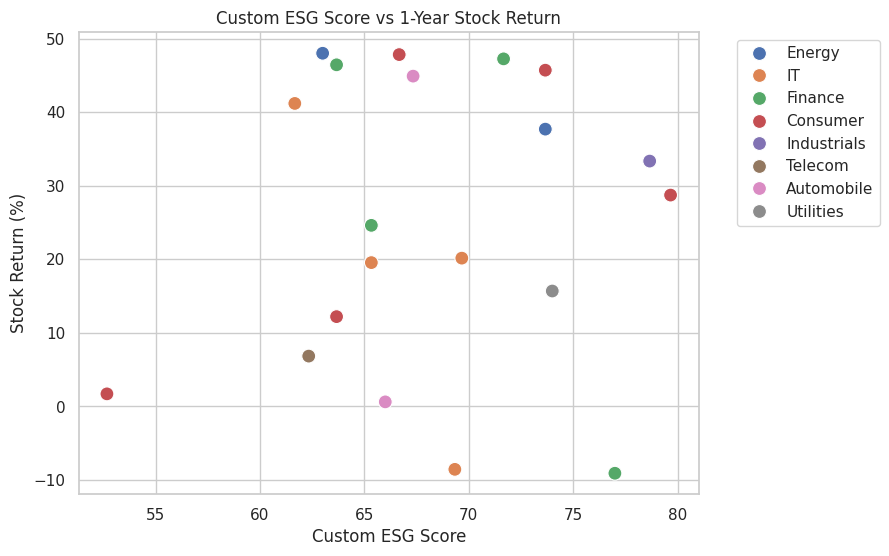

Correlation between Custom ESG Score and 1-Year Stock Return: 0.09
Correlation between Governance Score and 1-Year Stock Return: -0.04


In [25]:
# ---------------------------
# Top 5 Companies by Custom ESG
top5_esg = full_esg.sort_values(by='Custom_ESG', ascending=False).head(5)
print("Top 5 Companies by Custom ESG Score:")
display(top5_esg[['Company','Sector','Country','Custom_ESG']])

# ---------------------------
# Top 5 Companies by Governance Score
top5_gov = full_esg.sort_values(by='Governance_score', ascending=False).head(5)
print("Top 5 Companies by Governance Score:")
display(top5_gov[['Company','Sector','Country','Governance_score']])

# ---------------------------
# Sector-wise Average ESG
sector_avg = full_esg.groupby('Sector')['Custom_ESG'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=sector_avg.index, y=sector_avg.values, palette='viridis')
plt.title('Average Custom ESG Score by Sector')
plt.ylabel('Average ESG Score')
plt.xticks(rotation=45)
plt.show()

# ---------------------------
# ESG vs Governance Scatter
plt.figure(figsize=(8,6))
sns.scatterplot(x='Custom_ESG', y='Governance_score', data=full_esg, hue='Sector', s=100)
plt.title('Custom ESG Score vs Governance Score')
plt.xlabel('Custom ESG Score')
plt.ylabel('Governance Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ---------------------------
# Optional: ESG vs Stock Return
plt.figure(figsize=(8,6))
sns.scatterplot(x='Custom_ESG', y='StockReturn_1Y_pct', data=full_esg, hue='Sector', s=100)
plt.title('Custom ESG Score vs 1-Year Stock Return')
plt.xlabel('Custom ESG Score')
plt.ylabel('Stock Return (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Correlation
corr_esg_return = full_esg['Custom_ESG'].corr(full_esg['StockReturn_1Y_pct'])
corr_gov_return = full_esg['Governance_score'].corr(full_esg['StockReturn_1Y_pct'])
print(f"Correlation between Custom ESG Score and 1-Year Stock Return: {corr_esg_return:.2f}")
print(f"Correlation between Governance Score and 1-Year Stock Return: {corr_gov_return:.2f}")